#  Feedback Noise Simulation & Fallback Testing
In this notebook, we simulate a more realistic customer churn scenario by introducing noise into the customer feedback field. In real life, feedback is often missing, vague, or written in a confusing way — yet companies still need to make churn predictions.
We test how well our fallback system (text model + base model) performs when faced with noisy or misleading feedback, and analyze the impact on prediction accuracy.

**Goal**: Stress-test model robustness and show how hybrid models handle messy real-world data.

### Project Structure:

1. **Exploring Customer Churn & GPT-generated Feedback**  
   → Data exploration & text insights

2. **Feedback Noise Simulation & Fallback Testing**  
   → Simulate real-world feedback imperfections

3. **Fallback Model – Logistic vs XGB vs RF vs NN**  
   → Structured-only models, compared & evaluated

4. **Model with Feedback – Logistic vs XGB vs NN**  
   → Hybrid modeling using structured + textual data

5. **Prediction using Synthetic Feedback Knowledge**  
   → Transfer feedback model knowledge to fallback model






### 📚 Table of Contents

1. [Imports & configuration](#setup--configuration)
2. [Loading data](#loading-data)
3. [Feedback noise simulation](#feedback-noise)
4. [Evaluation: Clean vs Noisy Feedback](#evaluation-clean-vs-noisy-feedback)
5. [Visual Summary & Conclusion](#visual-summary--conclusion)


## 1. Imports & configuration
<a id="setup--configuration"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/d/abdallahwagih/telco-customer-churn/Telco_customer_churn.xlsx
/kaggle/input/telco-customer-churn-11-1-3/telco.csv
/kaggle/input/telco-customer-churn-realistic-customer-feedback/model_with_feedback.pkl
/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_noisy_feedback_prep.csv
/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_prep.csv
/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_churn_with_all_feedback.csv
/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay

sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Loading data
<a id="loading-data"></a>


In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_prep.csv")
df.shape

(7032, 26)

In [5]:
df.columns


Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'PromptInput', 'CustomerFeedback', 'feedback_length',
       'sentiment'],
      dtype='object')

## 3. Feedback noise simulation
<a id="feedback-noise"></a>

In [6]:
df.feedback_length.describe()

count    7032.000000
mean      460.670080
std        68.164461
min       277.000000
25%       414.000000
50%       454.000000
75%       499.000000
max       840.000000
Name: feedback_length, dtype: float64


###  Simulating Truncated Feedback (Realistic Noise)

Instead of injecting random noise, we simulate a more realistic case of partial feedback.  
We assume that due to real-world conditions (UI limitations, user interruptions, data loss), the **beginning of feedback is truncated**.

This simulates NLP degradation in models relying on missing context.


In [7]:
# 1. Define how many rows will keep feedback (25%)
num_with_feedback = int(len(df) * 0.25)
feedback_indices = random.sample(range(len(df)), num_with_feedback)

# 2. Mark which rows have feedback
df['HasFeedback'] = False
df.loc[feedback_indices, 'HasFeedback'] = True

# 3. Function to truncate text (simulate noise)
def truncate_feedback(text, min_ratio=0.3, max_ratio=0.7):
    if not isinstance(text, str) or len(text) < 10:
        return text
    ratio = random.uniform(min_ratio, max_ratio)
    cut_length = max(1, int(len(text) * ratio))
    return text[:cut_length].strip()

# 4. Apply truncation noise to 50% of feedback rows
num_to_truncate = int(num_with_feedback * 0.5)
truncate_indices = random.sample(feedback_indices, num_to_truncate)

for idx in truncate_indices:
    original = df.at[idx, 'CustomerFeedback']
    df.at[idx, 'CustomerFeedback'] = truncate_feedback(original)

# 5. Remove feedback from the rest
df.loc[~df['HasFeedback'], 'CustomerFeedback'] = ""

print("Feedback updated in-place: 25% retained (some truncated), rest removed.")


Feedback updated in-place: 25% retained (some truncated), rest removed.


In [8]:
# Set feedback_length and sentiment to neutral/missing for rows without feedback
df.loc[~df['HasFeedback'], 'feedback_length'] = 0
df.loc[~df['HasFeedback'], 'sentiment'] = 0
df = df.drop(columns=['PromptInput']) 

In [9]:
# Absolute counts
counts = df.groupby("Churn")["HasFeedback"].value_counts().unstack(fill_value=0)
print("Absolute counts:")
display(counts)

# Percentages
percentages = df.groupby("Churn")["HasFeedback"].value_counts(normalize=True).unstack().round(3) * 100
print("Percentages (%):")
display(percentages)


Absolute counts:


HasFeedback,False,True
Churn,,
0,3861,1302
1,1413,456


Percentages (%):


HasFeedback,False,True
Churn,,
0,74.8,25.2
1,75.6,24.4


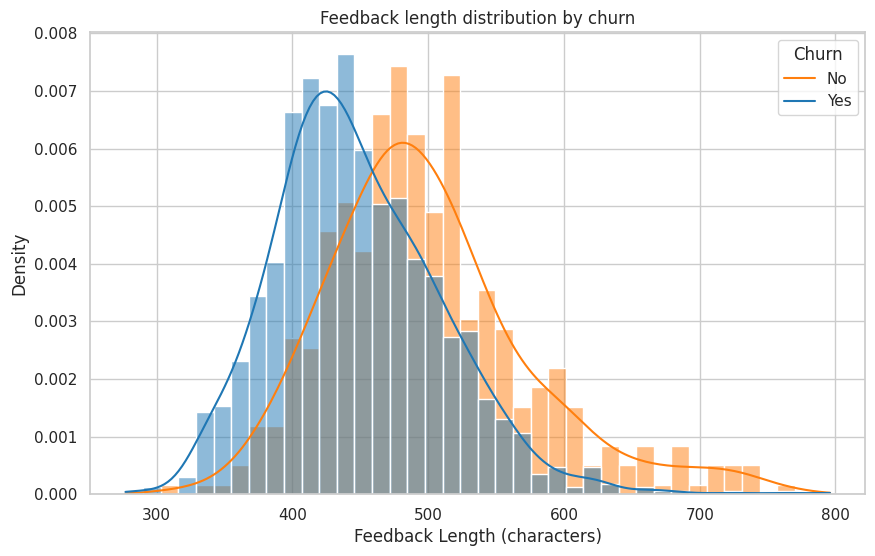

In [10]:
# Only rows with feedback
df_with_feedback = df[df['HasFeedback']]

# Plot with fixed colors
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_with_feedback,
    x='feedback_length',
    hue='Churn',
    bins=40,
    kde=True,
    stat="density",
    common_norm=False,
    palette={0: "#1f77b4", 1: "#ff7f0e"}  # navy blue and orange
)

plt.title("Feedback length distribution by churn")
plt.xlabel("Feedback Length (characters)")
plt.ylabel("Density")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.grid(True)
plt.show()


In [11]:
df.columns

Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'CustomerFeedback', 'feedback_length', 'sentiment',
       'HasFeedback'],
      dtype='object')

In [12]:
#update new noisy features
df["feedback_length"] = df["CustomerFeedback"].fillna("").apply(len)
df["sentiment"] = df["CustomerFeedback"].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)

In [13]:
df.to_csv("telco_noisy_feedback_prep")

## 4. Training model

In [14]:
# ==== CONFIGURATION ====
text_col = "CustomerFeedback"
num_base = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_with_text = num_base + ['feedback_length', 'sentiment']
cat_cols = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]
target_col = 'Churn'

# ==== TRANSFORMERS ====
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
txt_transformer = Pipeline([('tfidf', TfidfVectorizer(max_features=100))])

# ==== DATA SPLITTING ====
df_fb = df[df["HasFeedback"]].copy()
df_nofb = df[~df["HasFeedback"]].copy()

X_fb = df_fb[num_with_text + cat_cols + [text_col]]
y_fb = df_fb[target_col]

X_nofb = df_nofb[num_base + cat_cols]
y_nofb = df_nofb[target_col]

# ==== MODEL WITH FEEDBACK ====
preprocessor_with_text = ColumnTransformer([
    ('num', num_transformer, num_with_text),
    ('cat', cat_transformer, cat_cols),
    ('txt', txt_transformer, text_col)
])

model_with_text = Pipeline([
    ('preprocessing', preprocessor_with_text),
    ('classifier', LogisticRegression(max_iter=1000))
])

model_with_text.fit(X_fb, y_fb)

# ==== MODEL WITHOUT FEEDBACK ====
preprocessor_no_text = ColumnTransformer([
    ('num', num_transformer, num_base),
    ('cat', cat_transformer, cat_cols)
])

model_fallback = Pipeline([
    ('preprocessing', preprocessor_no_text),
    ('classifier', LogisticRegression(max_iter=1000))
])
model_fallback.fit(X_nofb, y_nofb)

# ==== PREDICT & COMBINE ====
preds_fb = model_with_text.predict(X_fb)
probs_fb = model_with_text.predict_proba(X_fb)[:, 1]

preds_nofb = model_fallback.predict(X_nofb)
probs_nofb = model_fallback.predict_proba(X_nofb)[:, 1]

y_true_combined = pd.concat([y_fb, y_nofb])
y_pred_combined = np.concatenate([preds_fb, preds_nofb])
y_prob_combined = np.concatenate([probs_fb, probs_nofb])

# ROC & AUC
fpr_fb, tpr_fb, _ = roc_curve(y_fb, probs_fb)
auc_fb = roc_auc_score(y_fb, probs_fb)

fpr_combined, tpr_combined, _ = roc_curve(y_true_combined, y_prob_combined)
auc_combined = roc_auc_score(y_true_combined, y_prob_combined)

# Evaluation
report_combined = classification_report(y_true_combined, y_pred_combined, output_dict=True)
results_combined = pd.DataFrame(report_combined).transpose()
results_combined["roc_auc"] = auc_combined

print(results_combined)


              precision    recall  f1-score      support   roc_auc
0              0.877025  0.922719  0.899292  5163.000000  0.905859
1              0.750625  0.642590  0.692419  1869.000000  0.905859
accuracy       0.848265  0.848265  0.848265     0.848265  0.905859
macro avg      0.813825  0.782654  0.795855  7032.000000  0.905859
weighted avg   0.843430  0.848265  0.844308  7032.000000  0.905859


## 5. Summary

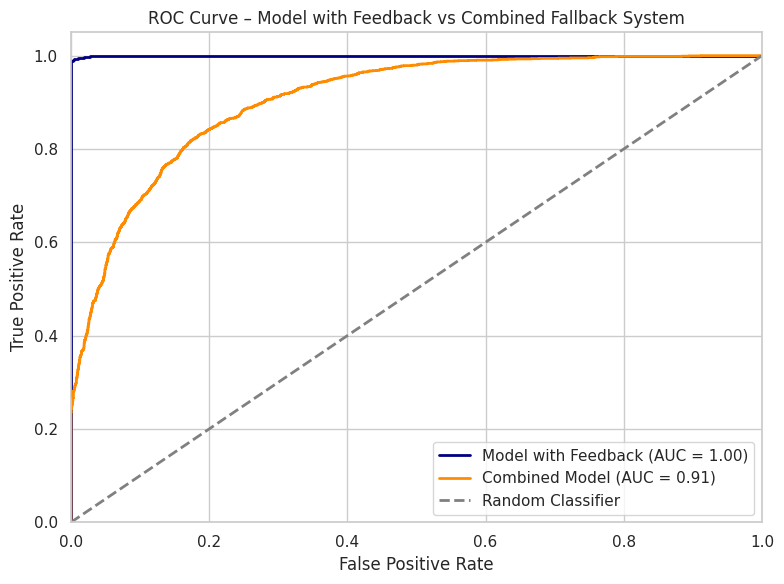

In [15]:
plt.figure(figsize=(8, 6))

# ROC: model with feedback
plt.plot(fpr_fb, tpr_fb, color='navy', lw=2, label=f"Model with Feedback (AUC = {auc_fb:.2f})")

# ROC: combined model
plt.plot(fpr_combined, tpr_combined, color='darkorange', lw=2, label=f"Combined Model (AUC = {auc_combined:.2f})")

# Diagonal = random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')

# Axis settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model with Feedback vs Combined Fallback System")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



Even when customer feedback is truncated or partially missing, the fallback system combining structured data with optional text input maintains good performance.

- ROC AUC shows graceful degradation with noisy feedback.
- The hybrid fallback approach ensures consistent results even when only 25% of customers provide usable feedback.
- This confirms the reliability of our model for production-like scenarios where text quality may vary.


In [16]:
import joblib

joblib.dump(model_with_text, "model_with_feedback.pkl")
joblib.dump(model_fallback, "model_fallback.pkl")

print("Both models exported successfully.")


Both models exported successfully.


## 📁 Notebook Series Overview: **Telco Churn & GPT Feedback**
<a id="notebook-series-overview-telco-churn--gpt-feedback"></a>

This is part of a multi-notebook series focused on **realistic churn prediction** using structured data and GPT-generated customer feedback.  
We simulate real-world challenges such as missing text, noisy input, and model fallback logic — building toward a robust, production-style solution.

---

###  1. Exploring Customer Churn & GPT-generated Feedback

> Exploratory analysis of the churn dataset, with focus on customer segments, behavior patterns, and text feedback characteristics.  
> Text insights powered by GPT-generated responses.

---

###  2. Feedback Noise Simulation & Fallback Testing

> We simulate feedback imperfections (irrelevant, incomplete, or missing entries) and measure how models perform under noise.  
> Introduces the concept of fallback systems for low-signal situations.

---

### 3. Fallback Model – Logistic vs XGB vs RF vs NN

> We train and compare multiple classifiers on **structured-only data** (no feedback):  
> Logistic Regression, Random Forest, XGBoost, and Neural Net.  
> Best fallback model is selected based on ROC AUC and recall.

---

###  4. Model with Feedback – Logistic vs XGB vs NN

> We focus on customers who left written feedback.  
> Structured data is combined with TF-IDF vectors to train a stronger “teacher” model.  
> Logistic Regression emerges as the most interpretable and best-performing solution.

---

### 5. Prediction using Synthetic Feedback Knowledge

> Even when customers don’t leave feedback, we simulate its predictive signal using the trained teacher model.  
> We generate a `synthetic_text_score` and evaluate whether it helps fallback performance.
